In [3]:
pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 112.4 MB/s eta 0:00:0000:010:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [34]:
import matplotlib.pyplot as plt
from PIL import Image
import os, random, shutil
from pathlib import Path
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import os
from torch.utils.data import DataLoader, random_split

## Get the dataset

In [13]:
!git clone https://github.com/Clement-Lelievre/sem_seg.git

Cloning into 'sem_seg'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 176 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (176/176), 29.58 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [14]:
!ls sem_seg

'Tile 1'  'Tile 3'  'Tile 5'  'Tile 7'	 classes.json
'Tile 2'  'Tile 4'  'Tile 6'  'Tile 8'


In [15]:
!ls 'sem_seg/Tile 3/masks'

image_part_001.png  image_part_004.png	image_part_007.png
image_part_002.png  image_part_005.png	image_part_008.png
image_part_003.png  image_part_006.png	image_part_009.png


In [16]:
!ls 'sem_seg/Tile 7/images'

image_part_001.jpg  image_part_004.jpg	image_part_007.jpg
image_part_002.jpg  image_part_005.jpg	image_part_008.jpg
image_part_003.jpg  image_part_006.jpg	image_part_009.jpg


In [19]:
try:
  shutil.rmtree('./dataset')
except FileNotFoundError:
  pass

os.makedirs('./dataset')
for subfolder in ['images', 'masks']:
  os.makedirs(f'./dataset/{subfolder}', exist_ok=True)

print(f"{os.listdir('./dataset')=}")
for dir_num, dir in enumerate(sorted(os.listdir('./sem_seg'))):
  if 'Tile' not in dir: continue
  for subfolder in os.listdir(f'sem_seg/{dir}'):
    #print(f"copying {dir}/{subfolder} contents")
    for file_num, fname in enumerate(sorted(Path(f'sem_seg/{dir}/{subfolder}').iterdir())):
      new_name = f"./dataset/{subfolder}/{dir_num}_{file_num}_{fname.name}"
      print(f"moving {Path(fname).absolute()!s} to {new_name}")
      #os.system(f'cp sem_seg/{dir}/{subfolder}/{file} {new_name}')
      shutil.copy(f'sem_seg/{dir}/{subfolder}/{fname.name}', new_name)

os.listdir('./dataset')=['images', 'masks']
moving /home/ubuntu/Developments/github.com/scenario-labs/sem_seg/Tile 1/images/image_part_001.jpg to ./dataset/images/1_0_image_part_001.jpg
moving /home/ubuntu/Developments/github.com/scenario-labs/sem_seg/Tile 1/images/image_part_002.jpg to ./dataset/images/1_1_image_part_002.jpg
moving /home/ubuntu/Developments/github.com/scenario-labs/sem_seg/Tile 1/images/image_part_003.jpg to ./dataset/images/1_2_image_part_003.jpg
moving /home/ubuntu/Developments/github.com/scenario-labs/sem_seg/Tile 1/images/image_part_004.jpg to ./dataset/images/1_3_image_part_004.jpg
moving /home/ubuntu/Developments/github.com/scenario-labs/sem_seg/Tile 1/images/image_part_005.jpg to ./dataset/images/1_4_image_part_005.jpg
moving /home/ubuntu/Developments/github.com/scenario-labs/sem_seg/Tile 1/images/image_part_006.jpg to ./dataset/images/1_5_image_part_006.jpg
moving /home/ubuntu/Developments/github.com/scenario-labs/sem_seg/Tile 1/images/image_part_007.jpg to ./

## view some random images from the dataset

RGB RGB RGB RGB


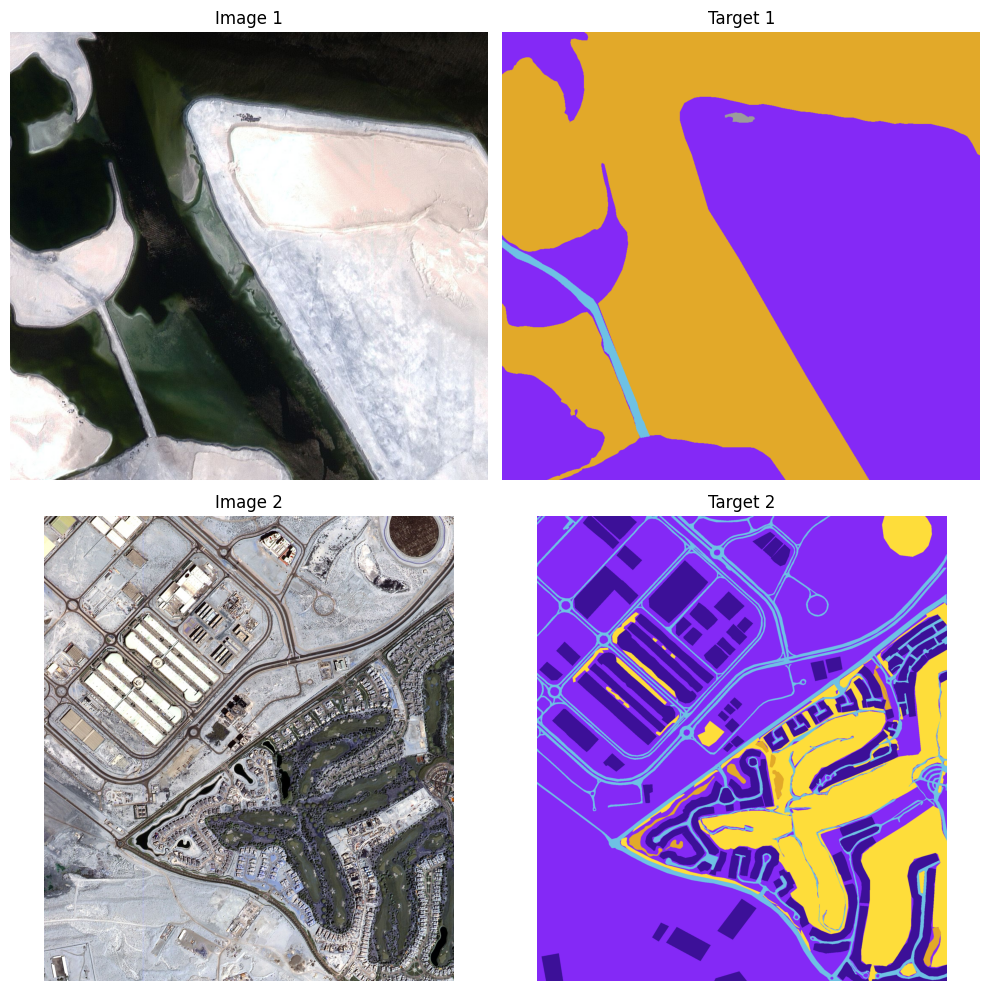

In [30]:
# Load the images
a,b = random.randint(0, 71), random.randint(0, 71)

x1 = Image.open(sorted(Path(os.path.join('dataset', 'images')).iterdir())[a])
y1 = Image.open(sorted(Path(os.path.join('dataset', 'masks')).iterdir())[a])
x2 = Image.open(sorted(Path(os.path.join('dataset', 'images')).iterdir())[b])
y2 = Image.open(sorted(Path(os.path.join('dataset', 'masks')).iterdir())[b])

print(x1.mode, y1.mode, x2.mode, y2.mode)


# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display the images in the grid
axs[0, 0].imshow(x1)
axs[0, 0].set_title('Image 1')
axs[0, 0].axis('off')

axs[0, 1].imshow(y1)
axs[0, 1].set_title('Target 1')
axs[0, 1].axis('off')

axs[1, 0].imshow(x2)
axs[1, 0].set_title('Image 2')
axs[1, 0].axis('off')

axs[1, 1].imshow(y2)
axs[1, 1].set_title('Target 2')
axs[1, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [25]:
COLORS = [
               (155, 155, 155), # unlabelled
               (60, 16, 152),  # building
               (132, 41, 246), # land
               (110, 193, 228), # road
               (254, 221, 58), # vegetation
               (226, 169, 41), # boat
               
]

COLOR_MAP = {color: i for i, color in enumerate(COLORS)}

COLOR_MAP

{(155, 155, 155): 0,
 (60, 16, 152): 1,
 (132, 41, 246): 2,
 (110, 193, 228): 3,
 (254, 221, 58): 4,
 (226, 169, 41): 5}

(often the unlabelled data has index 0)

## Check dataset

Are our images all RGB?

In [28]:
for path in Path('dataset/images').glob('*.jpg'):
    img = Image.open(path)
    if img.mode != "RGB":
        print(f"Converting {path} mode from {img.mode} to RGB")
        img = img.convert("RGB")
        img.save(path)

Are the targets all RGB?

In [31]:
for path in Path('dataset/masks').glob('*.png'):
    img = Image.open(path)
    if img.mode != "RGB":
        print(f"Converting {path} mode from {img.mode} to RGB")
        img = img.convert("RGB")
        img.save(path)

Converting dataset/masks/4_7_image_part_008.png mode from P to RGB
Converting dataset/masks/4_2_image_part_003.png mode from P to RGB
Converting dataset/masks/2_5_image_part_006.png mode from P to RGB
Converting dataset/masks/4_5_image_part_006.png mode from P to RGB
Converting dataset/masks/4_0_image_part_001.png mode from P to RGB
Converting dataset/masks/4_6_image_part_007.png mode from P to RGB
Converting dataset/masks/2_0_image_part_001.png mode from P to RGB
Converting dataset/masks/2_3_image_part_004.png mode from P to RGB
Converting dataset/masks/2_8_image_part_009.png mode from P to RGB
Converting dataset/masks/2_7_image_part_008.png mode from P to RGB
Converting dataset/masks/4_8_image_part_009.png mode from P to RGB
Converting dataset/masks/4_1_image_part_002.png mode from P to RGB
Converting dataset/masks/2_6_image_part_007.png mode from P to RGB
Converting dataset/masks/2_2_image_part_003.png mode from P to RGB
Converting dataset/masks/4_4_image_part_005.png mode from P to

Some of them were in 'palette' mode

Do our targets really have only these 6 pixels?

In [38]:
valid_colors = np.array(COLORS)
nb_invalid = 0
count = 0

for path in Path('./dataset/masks').glob('*.png'):    
    img = np.array(Image.open(path))
    count += 1
    unique_pixels = np.unique(img.reshape(-1, img.shape[2]), axis=0)
    if not np.all(np.isin(unique_pixels, valid_colors)):
        print(f"{path} contains invalid colors: {[pix for pix in unique_pixels if pix not in valid_colors]}")
        nb_invalid += 1
        # replace the bad pixels with pixel [155, 155, 155]
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if tuple(img[i, j]) not in COLORS:
                    img[i, j] = [155, 155, 155]
        Image.fromarray(img).save(path)

        
print(f"Found {nb_invalid} invalid images") 
assert count == 72       


dataset/masks/5_1_image_part_002.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
dataset/masks/8_2_image_part_003.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
dataset/masks/8_1_image_part_002.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
dataset/masks/3_5_image_part_006.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
dataset/masks/7_8_image_part_009.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
dataset/masks/7_1_image_part_002.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
dataset/masks/3_6_image_part_007.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
dataset/masks/6_5_image_part_006.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
dataset/masks/6_4_image_part_005.png contains invalid colors: [array([0, 0, 0], dtype=uint8)]
Found 9 invalid images


## make sure every mask is still RGB

In [39]:
for path in Path('dataset/masks').glob('*.png'):
    img = Image.open(path)
    if img.mode != "RGB":
        print(f"Converting {path} mode from {img.mode} to RGB")
        img = img.convert("RGB")
        img.save(path)

## Create the masks

so now every target has only the valid pixels, we need to use the color mapping to build the masks we'll give to the model as target output

In [42]:
!mkdir -p dataset/labels && ls dataset

images	labels	masks


In [48]:
unique_expected_labels = set(range(len(COLORS)))

for path in Path('dataset/masks').glob('*.png'):
    img = Image.open(path)
    mask = np.zeros((img.size[1], img.size[0]), dtype=np.uint8)
    for i, color in enumerate(COLORS):
        mask[np.all(np.array(img) == color, axis=-1)] = i
    
    assert set(np.unique(mask)).issubset(unique_expected_labels), f"found {np.unique(mask)} in {path}"
    mask_img = Image.fromarray(mask)
    assert mask_img.mode == 'L'
    mask_img.save(f"dataset/labels/{path.name}")

## Common sense questions before diving into the code

- can I solve this problem only using classical programming? Yes! Just kidding

- can I solve it using less resource-intensive ML? Possibly but DL is likely indeed the best approach

- what is a baseline to beat? the dummy baseline is to randomly assign a pixel among the valid ones, but better is to assign the most frequent one. Still this'd give very poor results

## Create dataset class

In [202]:
# Define a custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png")) 
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
        # convert the mask to a tensor
        mask = torch.from_numpy(np.array(mask.resize((256, 256), Image.NEAREST))).long()
        
        return image, mask

In [203]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # I need to apply the same preprocessing as the base model was trained on
])

In [204]:
dataset = SegmentationDataset(image_dir="dataset/images", mask_dir="dataset/labels", transform=transform)

# Define the split ratio
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Print the sizes of the datasets
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")

Training set size: 57
Validation set size: 15


In [205]:
# Load pre-trained FCN model and modify the final layer for 6 classes
model = models.segmentation.fcn_resnet50(pretrained=True)  # syntax that looks more recent: fcn_resnet50(weights=FCN_ResNet50_Weights, num_classes=6)
model.classifier[4] = nn.Conv2d(512, 6, kernel_size=1)  # Change output to 6 classes

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  #  multi-class classif
optimizer = optim.Adam(model.parameters(), lr=0.001)

Notes:

- given the small size of the dataset, and given more time, it'd be justified to do Kfold cross val
- it'd be a good idea to not only track the loss but also a metric like IoU or accuracy

## Training loop

Epoch [1/50], Training Loss: 0.5997456610202789
Epoch [1/50], Validation Loss: 0.6905922889709473
Epoch [2/50], Training Loss: 0.49529427886009214
Epoch [2/50], Validation Loss: 0.738536536693573
Epoch [3/50], Training Loss: 0.539710134267807
Epoch [3/50], Validation Loss: 0.660045437514782
Epoch [4/50], Training Loss: 0.5064247250556946
Epoch [4/50], Validation Loss: 0.7131014466285706
Epoch [5/50], Training Loss: 0.466846106449763
Epoch [5/50], Validation Loss: 0.6991155967116356
Epoch [6/50], Training Loss: 0.5989167630672455
Epoch [6/50], Validation Loss: 0.9227025359869003
Epoch [7/50], Training Loss: 0.5794638196627299
Epoch [7/50], Validation Loss: 0.8492535948753357
Epoch [8/50], Training Loss: 0.7732003808021546
Epoch [8/50], Validation Loss: 0.8596825897693634
Epoch [9/50], Training Loss: 0.7820828040440877
Epoch [9/50], Validation Loss: 0.9878603368997574
Epoch [10/50], Training Loss: 0.6883476277192434
Epoch [10/50], Validation Loss: 0.7146105170249939
Epoch [11/50], Traini

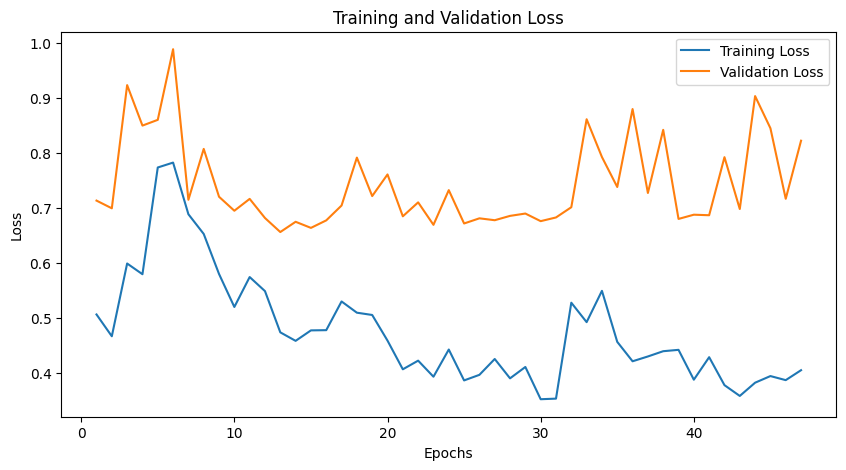

In [207]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device, dtype=torch.long).squeeze(1)
        
        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss}")
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device, dtype=torch.long).squeeze(1)
            val_outputs = model(val_images)['out']
            val_loss = criterion(val_outputs, val_masks)
            val_running_loss += val_loss.item()
    
    epoch_val_loss = val_running_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss}")

print("Training complete!")

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
train_losses_to_plot = train_losses[3:]  # because the first 3 epochs had very high loss values so they'd make the plot look bad due to the y axis scale
val_losses_to_plot = val_losses[3:]
plt.plot(range(1, len(train_losses_to_plot)+1), train_losses_to_plot, label='Training Loss')
plt.plot(range(1, len(val_losses_to_plot)+1), val_losses_to_plot, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Notes:

- can try other LRs
- can try higher batch size in order to have less variance in the loss

## Identify the spot where the model starts overfitting and retrain the model on the whole dataset

In [212]:
best_num_epochs = 30 # it was not clear from the plot where the validation loss stopped improving, so I'm just picking a number that seems reasonable

full_dataset = SegmentationDataset(image_dir="dataset/images", mask_dir="dataset/labels", transform=transform)
full_loader = DataLoader(full_dataset, batch_size=4, shuffle=True)

Reinstantiate a model, else the model will continue training from the last epoch

In [213]:
# Load pre-trained FCN model and modify the final layer for 6 classes
model = models.segmentation.fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, 6, kernel_size=1)  # Change output to 6 classes

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  #  multi-class classif
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/ubuntu/anaconda3/envs/inference_v2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/inference_v2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [214]:
num_epochs = best_num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in full_loader:
        images = images.to(device)
        masks = masks.to(device, dtype=torch.long).squeeze(1) 
        
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(full_loader)}")


Epoch [1/30], Loss: 1.405806495083703
Epoch [2/30], Loss: 1.1041823128859203
Epoch [3/30], Loss: 1.0265229509936438
Epoch [4/30], Loss: 0.929127554098765
Epoch [5/30], Loss: 0.9224186837673187
Epoch [6/30], Loss: 0.8962736891375648
Epoch [7/30], Loss: 0.8362304601404402
Epoch [8/30], Loss: 0.7873416907257504
Epoch [9/30], Loss: 0.7730900612142351
Epoch [10/30], Loss: 0.7550359964370728
Epoch [11/30], Loss: 0.8090625603993734
Epoch [12/30], Loss: 0.7203970750172933
Epoch [13/30], Loss: 0.7113574743270874
Epoch [14/30], Loss: 0.6897658970620897
Epoch [15/30], Loss: 0.6918485263983408
Epoch [16/30], Loss: 0.6510389281643761
Epoch [17/30], Loss: 0.6324091139766905
Epoch [18/30], Loss: 0.6374228315220939
Epoch [19/30], Loss: 0.6203279064761268
Epoch [20/30], Loss: 0.5703376680612564
Epoch [21/30], Loss: 0.5316217243671417
Epoch [22/30], Loss: 0.5162056320243411
Epoch [23/30], Loss: 0.5421206719345517
Epoch [24/30], Loss: 0.6113027483224869
Epoch [25/30], Loss: 0.6033231433894899
Epoch [26/3

## make an inference on a dataset image (but transforming it), to check results

In [215]:
def preprocess_image(image_path):    
    image = Image.open(image_path).convert('RGB')
    image = image.transpose(Image.FLIP_LEFT_RIGHT) # flip it
    image = transform(image).unsqueeze(0).to('cuda')  # Add batch dimension [1, C, H, W]
    return image

# Inference on the image
@torch.no_grad()
def infer(model, image_tensor):
    output = model(image_tensor)['out']  # Get the output of the FCN model
    output = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # Get the predicted class for each pixel
    return output

def inference_to_encoded_img(inference: np.ndarray) -> Image.Image:
    # Create an RGB image from the predicted classes
    h, w = inference.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
    for i, color in enumerate(COLORS):
        rgb_image[inference == i] = color
    return Image.fromarray(rgb_image)
    

(256, 256) [0 1 2 3 4 5]


(-0.5, 255.5, 255.5, -0.5)

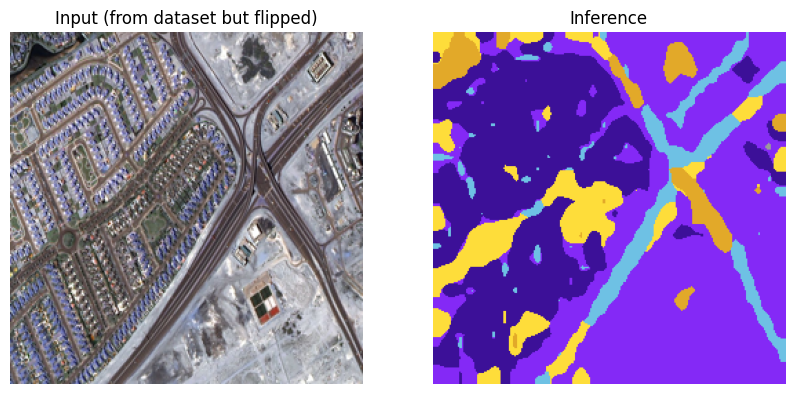

In [218]:
path = "dataset/images/4_6_image_part_007.jpg"

img = preprocess_image(path)
result = infer(model, img)
print(result.shape, np.unique(result))
inference = inference_to_encoded_img(result)

input_image = np.array(Image.open(path).resize((256, 256)))
input_image = input_image[:,::-1,:]  # flip the image horizontally
input_image = Image.fromarray(input_image)


# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Display the images in the grid
axs[0].imshow(input_image)
axs[0].set_title('Input (from dataset but flipped)')
axs[0].axis('off')

axs[1].imshow(inference)
axs[1].set_title('Inference')
axs[1].axis('off')

(256, 256) [1 2 3 4 5]


(-0.5, 255.5, 255.5, -0.5)

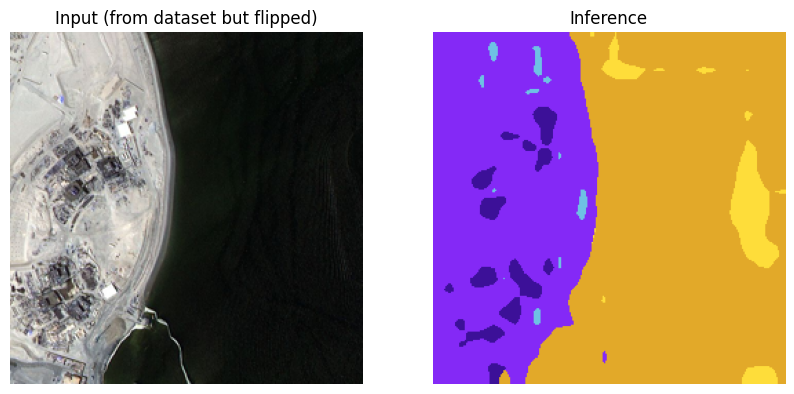

In [219]:
path = "dataset/images/3_6_image_part_007.jpg"

img = preprocess_image(path)
result = infer(model, img)
print(result.shape, np.unique(result))
inference = inference_to_encoded_img(result)

input_image = np.array(Image.open(path).resize((256, 256)))
input_image = input_image[:,::-1,:]  # flip the image horizontally
input_image = Image.fromarray(input_image)


# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Display the images in the grid
axs[0].imshow(input_image)
axs[0].set_title('Input (from dataset but flipped)')
axs[0].axis('off')

axs[1].imshow(inference)
axs[1].set_title('Inference')
axs[1].axis('off')

The model has clearly learnt, but it's not perfect

save the model

In [220]:
torch.save(model.state_dict(), 'sem_seg_model.pth')


it weighs 136mb on disk

/home/ubuntu/anaconda3/envs/inference_v2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/inference_v2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


(256, 256) [0 1 2 3 4 5]


(-0.5, 255.5, 255.5, -0.5)

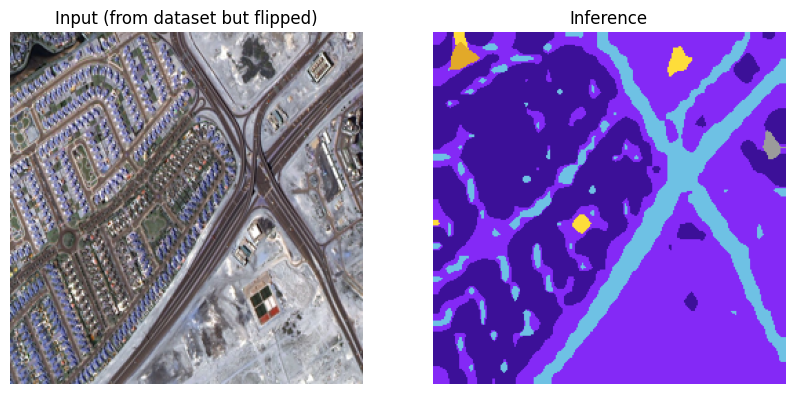

In [226]:
# load_the_model
model = models.segmentation.fcn_resnet50(pretrained=False, num_classes=6)
#model.classifier[4] = nn.Conv2d(512, 6, kernel_size=1)  # Change output to 6 classes
model.load_state_dict(torch.load('sem_seg_model.pth'), strict=False)
model.to('cuda')
model.eval()

path = "dataset/images/4_6_image_part_007.jpg"

img = preprocess_image(path)
result = infer(model, img)
print(result.shape, np.unique(result))
inference = inference_to_encoded_img(result)

input_image = np.array(Image.open(path).resize((256, 256)))
input_image = input_image[:,::-1,:]  # flip the image horizontally
input_image = Image.fromarray(input_image)


# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Display the images in the grid
axs[0].imshow(input_image)
axs[0].set_title('Input (from dataset but flipped)')
axs[0].axis('off')

axs[1].imshow(inference)
axs[1].set_title('Inference')
axs[1].axis('off')
    